<h1><center>Autoencoder on MNIST using Keras<center></h1>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

## Importing Keras

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
print("Using tensorflow version " + str(tf.__version__))
print("Using keras version " + str(keras.__version__))

Using tensorflow version 2.8.0
Using keras version 2.8.0


## Loading and preparing the MNIST dataset

Load the MNIST dataset via keras.datasets. Again, turn train and test labels into one-hot encoding, and reshape and normalize data as in the first exercise. 

In [3]:
# The MNSIT dataset is ready to be imported from Keras into RAM
# Warning: you cannot do that for larger databases (e.g., ImageNet)
from keras.datasets import mnist
# START CODE HERE
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()
# END CODE HERE

In [4]:
# Do you remember about one-hot encoding ?
from keras.utils.np_utils import to_categorical
# START CODE HERE
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes=10)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes=10)
# END CODE HERE

In [5]:
# Reshape to proper images with 1 color channel according to backend scheme
img_rows, img_cols = train_images.shape[1], train_images.shape[2]
train_images = train_images.reshape((train_images.shape[0], img_rows*img_cols))
# START CODE HERE
test_images = test_images.reshape((test_images.shape[0], img_rows*img_cols))
# END CODE HERE

# Cast pixels from uint8 to float32
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# Now let us normalize the images so that they have zero mean and standard deviation
# Hint: are real testing data statistics known at training time ?
# START CODE HERE
train_mean = np.mean(train_images)
train_std = np.std(train_images)
train_images = (train_images - train_mean)/train_std
test_mean = np.mean(test_images)
test_std = np.std(test_images)
test_images = (test_images - test_mean)/test_std
# END CODE HERE

## Autoencoder and PCA

First, we will try to connect the representation produced by Principal Component Analysis with what is learnt by a simple, linear, autoencoder. We will use the ```scikit-learn``` implementation of the ```PCA``` to obtain the two first components (hint: use the attribute ```.components_```), and visualize them:

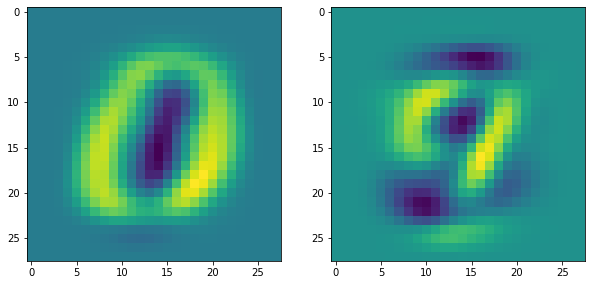

In [6]:
from sklearn.decomposition import PCA

# Let's find the first 2 PCA components
num_components = 2
# START CODE HERE
pca = PCA(n_components=2)
pca.fit(train_images)
principal_components = pca.components_
# END CODE HERE

# Reshape so they resemble images and we can print them
# START CODE HERE
principal_components = principal_components.reshape((2, 28, 28))
# END CODE HERE

# Show the reshaped principal components
# START CODE HERE
fig, ax = plt.subplots(1,2, figsize=(10,10)) 
ax[0].imshow(principal_components[0])
ax[1].imshow(principal_components[1])
plt.show()
# END CODE HERE

In [7]:
# Print the variance explained by those components
pca.explained_variance_

array([53.9014  , 39.411945], dtype=float32)

**Comment on the visualization in relation to the variance explained by only keeping the two principal components.**

> The first component almost draws a zero and gives about 50% of the information. This is expected because most of the ten digits have similarities with zero (except for 1 or 7 maybe). In the second component we can see a diagonal on the right which might be encoding the straight lines not captured by the first component.

Now, we will use Keras to implement the autoencoder. You can take a look at this [cheatsheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Keras_Cheat_Sheet_Python.pdf) for some basic commands to use keras.

In this first case, we implement a **simple linear autoencoder**. Build it in order to have the same capacity as the PCA decomposition (2 hidden dimensions !) we made just above. 

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD

In [9]:
# Input layer
input_layer = Input(shape = (img_rows*img_cols,), name="input")

In [10]:
# Encoding layer
latent_view = Dense(2, name="latent")(input_layer)

In [11]:
# Decoding layer
output_layer = Dense(img_rows*img_cols, name="output")(latent_view)

In [12]:
ae_model = Model(input_layer, output_layer, name='ae_model')
ae_model.summary()

Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 latent (Dense)              (None, 2)                 1570      
                                                                 
 output (Dense)              (None, 784)               2352      
                                                                 
Total params: 3,922
Trainable params: 3,922
Non-trainable params: 0
_________________________________________________________________


What loss shoud we use ? Choose the usual one and import it directly from Keras. You can use a simple ```SGD``` optimizer, and then compile the model; finally, train it to rebuild images from the original examples.  

In [13]:
from tensorflow.keras.losses import MeanSquaredError
loss = MeanSquaredError()

optimizer = SGD(lr=1e-1) 
ae_model.compile(optimizer=optimizer, loss=loss) 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [14]:
batch_size = 128
epochs = 10
# No noise here - we want to train a simple auto-encoder and compare visually with PCA
history = ae_model.fit(train_images,
                       train_images,
                       epochs=epochs,
                       batch_size=batch_size,
                       verbose=1,
                       shuffle=True,
                       validation_data=(test_images, test_images))

Epoch 1/10
469/469 [==============================] - 4s 7ms/step - loss: 0.7512 - val_loss: 0.6487
Epoch 2/10
469/469 [==============================] - 3s 6ms/step - loss: 0.6309 - val_loss: 0.6096
Epoch 3/10
469/469 [==============================] - 3s 6ms/step - loss: 0.6184 - val_loss: 0.6080
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6176 - val_loss: 0.6075
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6173 - val_loss: 0.6071
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6170 - val_loss: 0.6069
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6167 - val_loss: 0.6065
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6165 - val_loss: 0.6063
Epoch 9/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6162 - val_loss: 0.6062
Epoch 10/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6160 - val_loss: 0.6057

Assuming that the name of your layer (obtained through the command ```model.summary()```) is ```'layer'```, here is the way to obtained the weights. Visualize the weights of the encoder and compare them to the two components obtained through the PCA.

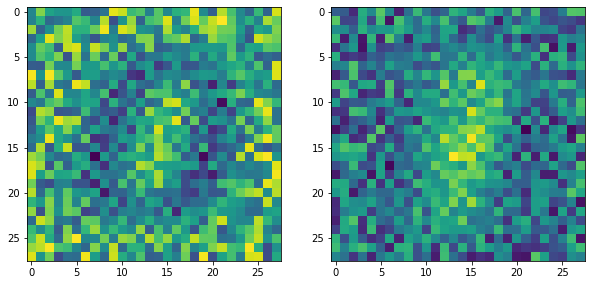

In [15]:
# Show the two dimensions of the encoder, in a similar manner to the principal components
# (after reshaping them as images !)
# START CODE HERE
latent_weights, latent_bias = ae_model.get_layer('latent').get_weights()

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(latent_weights[:,0].reshape(img_rows, img_cols))
ax[1].imshow(latent_weights[:,1].reshape(img_rows, img_cols))

plt.show()
# END CODE HERE

> These two components don't seem to capture as much information as the components given by PCA.

Now, visualize the images rebuild by the network !

In [16]:
# Select a few images at random: look from n
n = np.random.randint(0,len(test_images)-5)

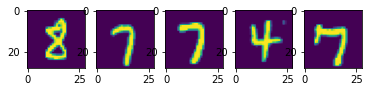

In [17]:
# Plot a few images from n  
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    # START CODE HERE
    ax[i].imshow(test_images[a].reshape(img_rows, img_cols))
    # END CODE HERE

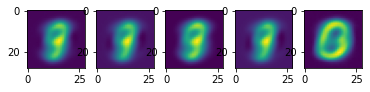

In [18]:
# Get the prediction from the model 
# START CODE HERE
autoencoded_imgs = ae_model.predict(test_images)
# END CODE HERE

# ... and plot them 
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    # START CODE HERE
    ax[i].imshow(autoencoded_imgs[a].reshape(img_rows, img_cols))
    # END CODE HERE

Do the same ( = build a new model) with a latent dimension that is largely higher than 2. Compare the visualizations and the images that are rebuilt. 

Epoch 1/10
469/469 [==============================] - 2s 4ms/step - loss: 0.6784 - val_loss: 0.5185
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.4556 - val_loss: 0.3947
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3748 - val_loss: 0.3395
Epoch 4/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3291 - val_loss: 0.3027
Epoch 5/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2977 - val_loss: 0.2768
Epoch 6/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2755 - val_loss: 0.2582
Epoch 7/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2590 - val_loss: 0.2438
Epoch 8/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2460 - val_loss: 0.2321
Epoch 9/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2354 - val_loss: 0.2226
Epoch 10/10
469/469 [==============================] - 2s 4ms/step - loss: 0.2267 - val_loss: 0.2148

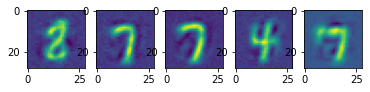

In [19]:
# START CODE HERE
ncomp = 32

input_layer2 = Input(shape=(img_cols*img_rows,), name="input2")
latent_view2 = Dense(ncomp, name="latent2")(input_layer2)
output_layer2 = Dense(img_rows*img_cols, name="output2")(latent_view2)
ae_model2 = Model(input_layer2, output_layer2)
ae_model2.compile(optimizer=optimizer, loss=loss)
history = ae_model2.fit(train_images,
                        train_images,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1,
                        shuffle=True,
                        validation_data=(test_images, test_images))

autoencoded_imgs2 = ae_model2.predict(test_images)
f, ax = plt.subplots(1,5)
for i,a in enumerate(range(n,n+5)):
    ax[i].imshow(autoencoded_imgs2[a].reshape(img_rows, img_cols))
# END CODE HERE

> As expected, with only two components the model cannot reconstruct the digits. However, with compression of factor 24.5 the model already behaves reasonably well.

## Denoising auto-encoder 

Now, we can implement a **de-noising autoencoder**. The following function will transform an array of images by adding it random noise. Create a new autoencoder model, this time with **more layers** and **non-linear activations** (like the ReLU) and train it to rebuild the de-noised images. Display some testing images, with noise, and re-built. 

In [20]:
def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )
    return noisy_array

In [21]:
# Create a copy of the data with added noise
noisy_train_images = noise(train_images)
noisy_test_images = noise(test_images)

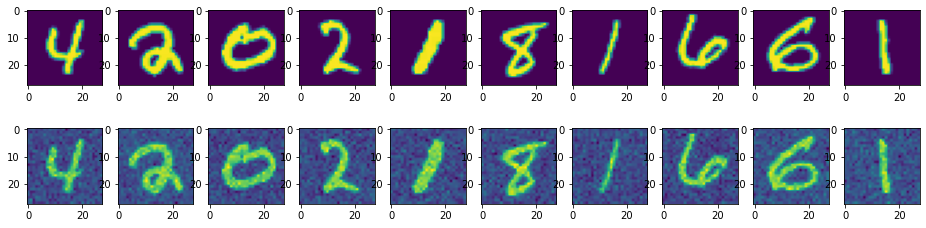

In [22]:
# Visualize some of the images with noise against the originals
# START CODE HERE
idx = np.random.randint(0, noisy_test_images.shape[0], 10)
fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i, n in enumerate(idx):
    ax[0][i].imshow(test_images[n].reshape(img_rows, img_cols))
    ax[1][i].imshow(noisy_test_images[n].reshape(img_rows, img_cols))
# END CODE HERE

In [23]:
# Build a new model with more layers and Relu activations
# START CODE HERE
input_layer3 = Input(shape=(img_cols*img_rows,))

encoded1 = Dense(128, activation='relu')(input_layer3)
encoded2 = Dense(64, activation='relu')(encoded1)
encoded3 = Dense(32, activation='relu')(encoded2)

decoded1 = Dense(64, activation='relu')(encoded3)
decoded2 = Dense(128, activation='relu')(decoded1)
output_layer3 = Dense(784, activation='relu')(decoded2)

ae_model3 = Model(input_layer3, output_layer3)
# END CODE HERE

In [24]:
# Compile it but here, use noised data as inputs !
# START CODE HERE
ae_model3.compile(optimizer=optimizer, loss=loss)
batch_size = 1024
epochs = 20
history = ae_model3.fit(noisy_train_images,
                        train_images,
                        epochs=epochs,
                        batch_size=batch_size,
                        verbose=1,
                        shuffle=True,
                        validation_data=(noisy_test_images, test_images))
# END CODE HERE

Epoch 1/20
59/59 [==============================] - 1s 13ms/step - loss: 0.9832 - val_loss: 0.9460
Epoch 2/20
59/59 [==============================] - 1s 11ms/step - loss: 0.8782 - val_loss: 0.8303
Epoch 3/20
59/59 [==============================] - 1s 10ms/step - loss: 0.8296 - val_loss: 0.8209
Epoch 4/20
59/59 [==============================] - 1s 10ms/step - loss: 0.8239 - val_loss: 0.8159
Epoch 5/20
59/59 [==============================] - 1s 10ms/step - loss: 0.8195 - val_loss: 0.8118
Epoch 6/20
59/59 [==============================] - 1s 10ms/step - loss: 0.8146 - val_loss: 0.8049
Epoch 7/20
59/59 [==============================] - 1s 10ms/step - loss: 0.8063 - val_loss: 0.7952
Epoch 8/20
59/59 [==============================] - 1s 10ms/step - loss: 0.7935 - val_loss: 0.7785
Epoch 9/20
59/59 [==============================] - 1s 10ms/step - loss: 0.7762 - val_loss: 0.7589
Epoch 10/20
59/59 [==============================] - 1s 10ms/step - loss: 0.7558 - val_loss: 0.7373
Epoch 11/

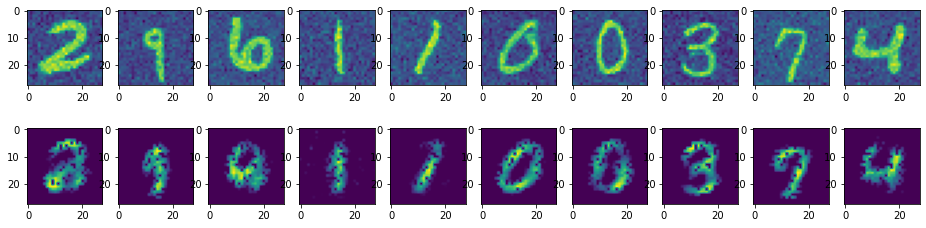

In [25]:
# Visualize the images rebuilt by the model !
# START CODE HERE
autoencoded_imgs3 = ae_model3.predict(test_images)

idx = np.random.randint(0, noisy_test_images.shape[0], 10)
fig, ax = plt.subplots(2, 10, figsize=(16, 4))
for i, n in enumerate(idx):
    ax[0][i].imshow(noisy_test_images[n].reshape(img_rows, img_cols))
    ax[1][i].imshow(autoencoded_imgs3[n].reshape(img_rows, img_cols))
# END CODE HERE

**Assuming that we normalize the images to be in the 0-1 range, what other loss function could we use ?**

> We could use the binary crossentropy or the Poisson loss for example.